<a href="https://colab.research.google.com/github/Gabendi/DL_HW/blob/master/DL_HW_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**https://github.com/EscVM/OIDv4_ToolKit használva a képek letöltéséhez**
a 3 kategória: dog,penguin,cat


In [0]:
#!git clone https://github.com/EscVM/OIDv4_ToolKit.git

In [0]:
#!python /content/OIDv4_ToolKit/main.py downloader --classes Dog Cat Penguin --type_csv train --limit 600

In [3]:
#imports
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
import numpy as np
import zipfile
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [0]:
#using .zip files from my computer, extracting them
local_zip_cats = '/content/Cat.zip'
local_zip_cats = zipfile.ZipFile(local_zip_cats,'r')
local_zip_cats.extractall('/content')
local_zip_cats.close()

local_zip_dogs = '/content/Dog.zip'
local_zip_dogs = zipfile.ZipFile(local_zip_dogs,'r')
local_zip_dogs.extractall('/content')
local_zip_dogs.close()

local_zip_penguin = '/content/Penguin.zip'
local_zip_penguin = zipfile.ZipFile(local_zip_penguin,'r')
local_zip_penguin.extractall('/content')
local_zip_penguin.close()

In [0]:
#dir names
base_dir = '/content'
dog_dir = os.path.join(base_dir, 'Dog')
cat_dir = os.path.join(base_dir, 'Cat')
penguin_dir = os.path.join(base_dir, 'Penguin')

In [0]:
dog_files = []
cat_files = []
penguin_files = []

for file_name in os.listdir(dog_dir): #collecting all dogs
    if file_name.endswith(".jpg"): 
        img = np.asarray(image.load_img(os.path.join(dog_dir,file_name), target_size=(300,300)))
        dog_files.append(img)

for file_name in os.listdir(cat_dir): #collecting all cats
    if file_name.endswith(".jpg"): 
        img = np.asarray(image.load_img(os.path.join(cat_dir,file_name), target_size=(300,300)))
        cat_files.append(img)

for file_name in os.listdir(penguin_dir): #collecting all penguins
    if file_name.endswith(".jpg"): 
        img = np.asarray(image.load_img(os.path.join(penguin_dir,file_name), target_size=(300,300)))
        penguin_files.append(img)

dog_files = dog_files[0:600]

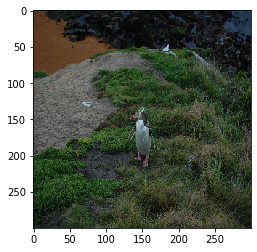

In [7]:
plt.imshow(penguin_files[2]) #just showing a pic if it works

In [0]:
#setting width+height
img_height = 260
img_width = 260

#seperating the data to sets
X_train = np.zeros((1200,300,300,3))
Y_train = np.zeros(1200)
X_valid = np.zeros((300,300,300,3))
Y_valid = np.zeros(300)


#creating the train dataset
X_train[0:400] = cat_files[0:400]
X_train[400:800] = dog_files[0:400]
X_train[800:1200] = penguin_files[0:400]

Y_train[0:400] = 0
Y_train[400:800] = 1
Y_train[800:1200] = 2
Y_train = to_categorical(Y_train) #one_hot encoding

#creating the validation dataset
X_valid[0:100] = cat_files[400:500]
X_valid[100:200] = dog_files[400:500]
X_valid[200:300] = penguin_files[400:500]

Y_valid[0:100] = 0
Y_valid[100:200] = 1
Y_valid[200:300] = 2
Y_valid = to_categorical(Y_valid) #one_hot encoding

#creating the test dataset
X_test = np.zeros((300,300,300,3))
Y_test = np.zeros(300)

X_test[0:100] = cat_files[500:600]
X_test[100:200] = dog_files[500:600]
X_test[200:300] = penguin_files[500:600]

Y_test[0:100] = 0
Y_test[100:200] = 1
Y_test[200:300] = 2
Y_test = to_categorical(Y_test) #one_hot encoding

for image in X_train: #preprocessing image for the convnet using the prepro. method suggested 
    preprocess_input(image)

for image in X_valid: #preprocessing image for the convnet using the prepro. method suggested 
    preprocess_input(image)

for image in X_test: #preprocessing image for the convnet using the prepro. method suggested 
    preprocess_input(image)

In [0]:
np.random.seed(123)

randpermt = np.random.permutation(1200)
#shuffling the data
X_train = np.array(X_train,dtype='float')[randpermt.astype(int)]
Y_train = np.array(Y_train,dtype='float')[randpermt.astype(int)]

randpermv = np.random.permutation(300)
X_valid = np.array(X_valid,dtype='float')[randpermv.astype(int)]
Y_valid = np.array(Y_valid,dtype='float')[randpermv.astype(int)]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0. 0.]


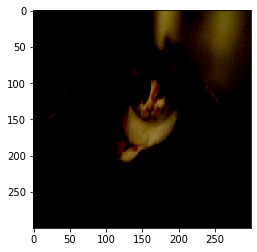

In [10]:
plt.imshow(X_train[156]) #showing a pic after the preprocess
print(Y_train[156])

In [11]:
#adding the imagenet
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
# adding the dense layers to the end
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
# we need 3 predictions, with softmax
predictions = Dense(3, activation='softmax')(x)
#creating the model itself
model = Model(inputs=base_model.input, outputs=predictions)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
for layer in base_model.layers:
    layer.trainable = False
#we dont teach the conv layers YET
model.compile(optimizer='adam', metrics=['accuracy'],loss='categorical_crossentropy')

In [13]:
history = model.fit(X_train,Y_train,epochs=6,batch_size=128,validation_data =(X_valid,Y_valid)) #training the model

Train on 1200 samples, validate on 300 samples
Epoch 1/6
1200/1200 [==============================] - 12s 10ms/sample - loss: 1.0766 - acc: 0.5933 - val_loss: 0.3114 - val_acc: 0.8933
Epoch 2/6
1200/1200 [==============================] - 5s 4ms/sample - loss: 0.2911 - acc: 0.9067 - val_loss: 0.3620 - val_acc: 0.8633
Epoch 3/6
1200/1200 [==============================] - 5s 4ms/sample - loss: 0.1978 - acc: 0.9258 - val_loss: 0.2049 - val_acc: 0.9267
Epoch 4/6
1200/1200 [==============================] - 5s 4ms/sample - loss: 0.1201 - acc: 0.9583 - val_loss: 0.4718 - val_acc: 0.8533
Epoch 5/6
1200/1200 [==============================] - 5s 4ms/sample - loss: 0.1497 - acc: 0.9450 - val_loss: 0.3942 - val_acc: 0.8833
Epoch 6/6
1200/1200 [==============================] - 5s 4ms/sample - loss: 0.0763 - acc: 0.9783 - val_loss: 0.4224 - val_acc: 0.9000


In [0]:
i=0 #the top 10 conv layers are learning from now on
layers_num = len(base_model.layers)
num_of_trained_layers = 10
for layer in base_model.layers:
  if i > layers_num - num_of_trained_layers:
    layer.trainable = True
  i += 1

In [15]:
#training the upper conv layers too
history = model.fit(X_train,Y_train,epochs=6,batch_size=128,validation_data =(X_valid,Y_valid))

Train on 1200 samples, validate on 300 samples
Epoch 1/6
1200/1200 [==============================] - 5s 4ms/sample - loss: 0.0508 - acc: 0.9817 - val_loss: 0.4838 - val_acc: 0.8933
Epoch 2/6
1200/1200 [==============================] - 5s 4ms/sample - loss: 0.0887 - acc: 0.9783 - val_loss: 1.1152 - val_acc: 0.8167
Epoch 3/6
1200/1200 [==============================] - 5s 4ms/sample - loss: 0.2469 - acc: 0.9258 - val_loss: 0.2140 - val_acc: 0.9433
Epoch 4/6
1200/1200 [==============================] - 5s 4ms/sample - loss: 0.1329 - acc: 0.9475 - val_loss: 0.4569 - val_acc: 0.8600
Epoch 5/6
1200/1200 [==============================] - 5s 4ms/sample - loss: 0.0451 - acc: 0.9900 - val_loss: 0.3143 - val_acc: 0.9267
Epoch 6/6
1200/1200 [==============================] - 5s 4ms/sample - loss: 0.0282 - acc: 0.9875 - val_loss: 0.3501 - val_acc: 0.9267


In [0]:
predictions = model.predict(X_test) #testing

In [0]:
bad_predictions_indices = []

for i in range(300):
  if np.argmax(predictions[i]) != np.argmax(Y_test[i]):
    bad_predictions_indices.append(i)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


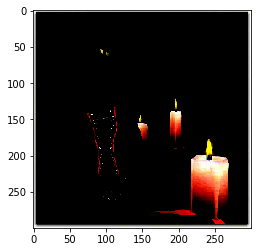

In [18]:
plt.imshow(X_test[bad_predictions_indices[4]])

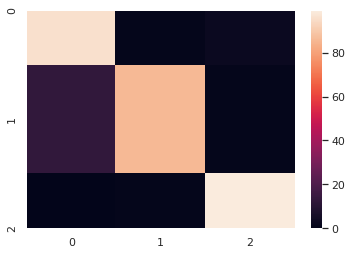

In [19]:
conf=confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(predictions,axis=1))
import seaborn as sns; sns.set() #penguins are OK, cats are OK, dogs are likely to be predicted as cats
sns.heatmap(conf)